## 随机矩阵的奇异值分析
### 随机矩阵的奇异值
在笔记[理解LSTM](./learning-lstm)一文中我们提到，权值矩阵$W_{rec}$的最大奇异值$s_{max}$对RNN算法的最终表现有显著影响。实际上，限制矩阵的谱半径是限制奇异值的一个特殊情况。我们先来看线性代数中的一条定理：
$$\rho(X)\leq \left\|X\right\|_2=s_{max}(X)$$
这条定理告诉我们，矩阵的谱半径不大于矩阵的谱范数（即最大奇异值），因此我们只要限制矩阵的谱范数，也就限制了矩阵的谱半径。   
### 正态分布初始化
假设我们用一个标准正态分布初始化权值矩阵，那么可以证明该矩阵的最大奇异值将和随机分布的标准差以及矩阵维度有关。文献[1]告诉我们一个结论：
> 设矩阵$A_{n\times n}$是一个随机矩阵，其每一项都是独立同分布的随机变量$\xi$，且$\mathbb{E}[\xi]=0$，$\mathbb{E}[\xi^2]=1$，$\mathbb{E}[\xi^4]<\infty$，则当$n\to\infty$时，有
$$s_{max}(A)\to 2\sqrt{n}$$

接下来我们来验证一下这个结论。我们用标准正态分布初始化权值矩阵，并观察矩阵维度从$5$到$250$时最大奇异值的变化情况（图中的蓝线），并将其与曲线$2\sqrt{n}$（图中红线）进行比对：


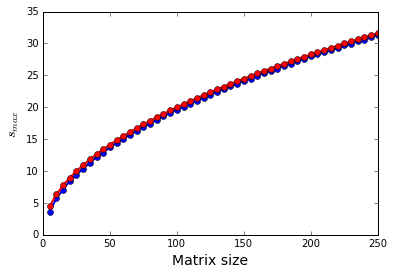

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

def get_max_singular(W):
    U, S, Vh = np.linalg.svd(W)
    return np.max(S)
sizes = range(5, 255, 5)
res = []
for size in sizes:
    singulars = []
    for i in xrange(100):
    # sample from standard gaussian distribution
        W = np.random.randn(size, size)
        singulars.append(get_max_singular(W))
    res.append(np.mean(singulars))
fig, ax = plt.subplots(1, 1)
ax.plot(sizes, res, 'o-', color='blue', lw=2)
ax.plot(sizes, 2 * np.sqrt(sizes), 'o-', color='red', lw=2)
ax.set_xlabel('Matrix size', fontsize=14)
ax.set_ylabel('$s_{max}$', fontsize=14)
plt.show()

通过观察我们发现，当我们固定标准差，逐渐增大矩阵大小时，最大奇异值也随着增大，且增大的速度恰好是$O(\sqrt{n})$的，与上述定理给出的结论一致。接着我们调查标准差变化对权值矩阵最大奇异值的影响，我们将矩阵大小固定为$10\times 10$，并在每个标准差的取值上我们生成1000次$W_{10}$，并对这些矩阵的最大奇异值求平均， 接着作出奇异值-标准差的散点图。

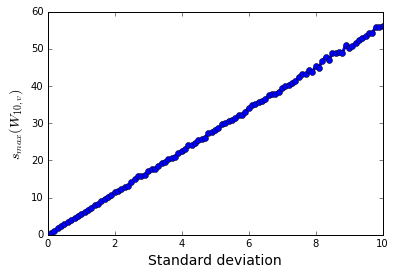

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

size = 10
res = []
std_vals = np.linspace(0.1, 10, 100)
for std in std_vals:
    singulars = []
    for i in xrange(100):
        W = np.random.randn(size, size) * std
        singulars.append(get_max_singular(W))
    res.append(np.mean(singulars))

fig, ax = plt.subplots(1, 1)
ax.plot(std_vals, res, '-o', color='blue', linewidth=3)
ax.set_xlabel('Standard deviation', fontsize=14)
ax.set_ylabel('$s_{max}(W_{10,v})$', fontsize=14)
plt.show()

由上图发现，标准差和最大奇异值呈正比，随着标准差增大，权值矩阵的奇异值也相应增大。因此当标准不为1时，我们可以得出以下结论：  
> 设矩阵$A_{n\times n}$是一个随机矩阵，其每一项都是独立同分布的随机变量$\xi$，且$\mathbb{E}[\xi]=0$，$\mathbb{E}[\xi^2]=\sigma^2$，$\mathbb{E}[\xi^4]<\infty$，则当$n\to\infty$时，有
$$s_{max}(A)\to 2\sqrt{n}\sigma$$


为验证上述结论是否正确，我们生成一个$1000\times 1000$的随机矩阵，其每一项由$\mathcal{N}(0, 2^2)$生成，我们计算矩阵的最大奇异值，与上述定理的理论值进行比较，编写代码如下：

In [3]:
std = 2
n = 1000
W = np.random.randn(n, n) * std
print "Maximum singular value={}, theoretical value={}".format(get_max_singular(W), 2*np.sqrt(n)*std)

Maximum singular value=125.864150196, theoretical value=126.491106407


可以看到实际值与理论收敛值非常接近。

那么有什么方法能将奇异值控制在1附近呢？  
实际上只要令$2\sqrt{n}\sigma=1$即$\sigma=\frac{1}{2\sqrt{n}}$就可以做到。于是我们有了如下的trick：
```py
n = 100
std = 1 / (2 * np.sqrt(n))
W = np.random.randn(n, n) * std
```
我们编写代码来验证一下这个trick是否奏效：

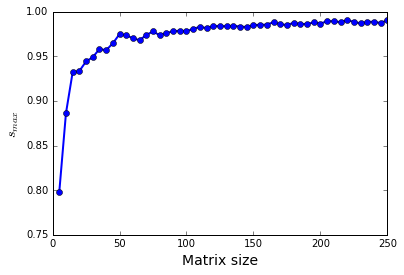

In [4]:
sizes = range(5, 255, 5)
res = []
for size in sizes:
    singulars = []
    std = 1 / (2 * np.sqrt(size))
    for i in xrange(100):
    # sample from standard gaussian distribution
        W = np.random.randn(size, size) * std
        singulars.append(get_max_singular(W))
    res.append(np.mean(singulars))
fig, ax = plt.subplots(1, 1)
ax.plot(sizes, res, 'o-', color='blue', lw=2)
ax.set_xlabel('Matrix size', fontsize=14)
ax.set_ylabel('$s_{max}$', fontsize=14)
plt.show()

可以看到，我们成功地将最大奇异值限制在了1左右（比1低一些是因为n还不够大），使用这个trick我们可以在初始化RNN的权值矩阵的时候将其奇异值控制在1附近，从而减小梯度消失/爆炸的影响。

### 均匀分布初始化
除了高斯分布，我们也可以尝试用均匀分布来初始化权值。给定一个$n$阶方阵$W_n$，我们要用均匀分布$U(a,b)$初始化$W_n$使其谱范数为1，首先要保证均匀分布的均值为0，只要取$a=b$即可，于是我们得到一个关于$x=0$对称的均匀分布$U(-a,a)$。均匀分布的方差为$\frac{(b-a)^2}{12}$，因此标准差为$\sigma=\frac{(b-a)}{\sqrt{12}}=\frac{2a}{\sqrt{12}}$。代入我们的目标式子：
$$ 2\sqrt{n}\frac{2a}{\sqrt{12}}=1$$
就有
$$a=\sqrt{\frac{3}{4n}}$$
因此我们用分布$U(-\sqrt{\frac{3}{4n}},\sqrt{\frac{3}{4n}})$初始化权值就能得到最大奇异值为1的$W_n$，我们可以写代码来验证这个结论：

In [5]:
n = 1000
W = np.random.uniform(-np.sqrt(3 / (4 * n)), np.sqrt(3 / (4 * n)), (n, n))
U, S, Vh = np.linalg.svd(W)
print "Maximum singular value={}, theoretical value={}".format(np.max(S), 1.0)

Maximum singular value=0.995906568667, theoretical value=1.0


这就解释了为什么有些神经网络代码喜欢用$U(-\frac{1}{\sqrt{n}},\frac{1}{\sqrt{n}})$来初始化权值，这么做是为了将谱范数限制在1左右。

这个结论可以推广到一般的矩阵上。对于一般的矩阵$A_{n\times m}$有如下的定理成立：

> 设矩阵$A_{n\times m}$是一个随机矩阵，其每一项都是独立同分布的随机变量$\xi$，且$\mathbb{E}[\xi]=0$，$Var[\xi]=\sigma^2$，$\mathbb{E}[\xi^4]<\infty$，假设当$m,n\to\infty$时，比值$m/n\to y\in(0,1]$，则有
$$\frac{1}{\sqrt{n}}s_{max}(A)\to 1+\sqrt{y}\sigma$$

当$m,n$都很大时，下式近似成立
$$s_{max}(A)\approx (\sqrt{n}+\sqrt{m})\sigma$$
对于均匀分布，由
$$\sigma = \frac{2a}{\sqrt{12}}=\frac{1}{\sqrt{n}+\sqrt{m}}$$
得
$$a=\frac{\sqrt{12}}{2(\sqrt{n}+\sqrt{m})}$$
下面我们用python来验证这个猜想是否正确

In [6]:
n, m = 1000, 500
a = np.sqrt(12)/(2 * (np.sqrt(n) + np.sqrt(m)))
W = np.random.uniform(-a, a, (n, m))
print "Maximum singular value={}, theoretical value={}".format(get_max_singular(W), 1.0)

Maximum singular value=0.997206103848, theoretical value=1.0


### 正交矩阵初始化
当权值矩阵是个方阵，我们经常用一个随机的正交矩阵来初始化。

In [7]:
W = np.random.randn(1000, 1000)
U, S, Vh = np.linalg.svd(W)
print get_max_singular(U)

1.0


我们可以看到，由于正交矩阵的谱范数为1，因此矩阵正交矩阵$U$的最大奇异值也为1，这就是有些代码中喜欢用随机正交矩阵初始化权值矩阵的原因。

### 正则化与奇异值的关系
有了前面的概念，我们很容易理解神经网络中的正则化，其实就是通过限制权值矩阵的谱范数来避免梯度爆炸，但是正则化却不能防止梯度消失，这是正则化的一个局限之处。

## 参考
1. [Non-asymptotic theory of random matrices: extreme singular values](https://arxiv.org/abs/1003.2990)
2. [THE SPECTRAL RADII AND NORMS OF LARGE DIMENSIONAL NON-CENTRAL RANDOM MATRICES](www4.ncsu.edu/~jack/murep.pdf)